In [1]:
import xesmf as xe
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
from matplotlib.colors import LogNorm
import xroms
import numpy as np
import seawater as sw
# import warnings
# warnings.filterwarnings("ignore")


In [2]:
#WRF
path='/data/pacific/lrenault/SASI/FULL/WRF/'
listm=glob(path+'*DAY.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[-9:])


path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listt=glob(path+'*DAY.nc');listt.sort()
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt)

#3D
# path='/data/pacific/lrenault/SASI/CROCO/FULL/'
# listm=glob(path+'SASI*.nc');listm.sort()
# # varf=xr.open_dataset(listm[-9:][xmon])
# varf=xr.open_mfdataset(listm)

# path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
# listt=glob(path+'SASI*.nc');listt.sort()
# #vart=xr.open_dataset(listt[xmon])
# vart=xr.open_mfdataset(listt)

In [3]:
import pyspec.spectrum as spec
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "lon" in coord][0]
    latkey = [coord for coord in var.coords if "lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder


/homes/metogra/iufarias/miniconda3/envs/ROMS/lib/python3.7/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


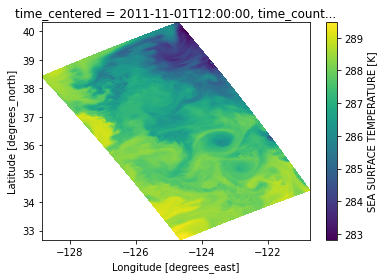

In [50]:
varf.SST[0].sel(x=range(10,215),y=range(10,380)).plot(x='nav_lon',y='nav_lat')
vtest=varf.sel(x=range(10,215),y=range(10,380))

In [49]:
vtest=vtest.drop(['time_centered_bounds','time_counter_bounds'])

In [ ]:
vari,_=regrid(vtest,vtest.nav_lon.data,vtest.nav_lat.data,which="grid")

In [231]:
# dx=((np.diff(varf.nav_lon[0,:])).mean() + np.diff(varf.nav_lon[-1,:]).mean())/2
# dy=np.abs((np.diff(varf.nav_lon[:,0])).mean() + np.diff(varf.nav_lon[:,-1]).mean())/2

In [33]:
dx=1.5e3
dy=1.5e3
a = 6371315.0 # CROCO Earth radius
m_per_deg = 2*np.pi*a/360

In [4]:
# dx = 1.5e3
# dy = dx

# # x = varf.dx.cumsum('nav_lon')
# # y = varf.dy.cumsum('nav_lat')

# sponge = 1
# # Calculate the length of a box fully contained in grid in lat
# trimlats = vtest.nav_lat[sponge:-sponge,sponge:-sponge]
# bottom_lat = np.max(trimlats[0,:])
# top_lat = np.min(trimlats[-1,:])
# deltalat = top_lat - bottom_lat
# ydistance = deltalat*m_per_deg
# yi = np.arange(0, ydistance, dy)
# # Calculate the length of a box fully contained in grid in lon
# trimlons = vtest.nav_lon[sponge:-sponge,sponge:-sponge]
# deltalons = trimlons-trimlons[:,0]
# distance = deltalons*m_per_deg*np.cos(trimlats*np.pi/180)
# latind = np.argmin(distance[:,-1].values) # find the eta index of the least distance in domain
# xi = np.arange(0, distance[latind,-1].values, dx)

# nx = xi.size
# ny = yi.size
# lonlim = np.linspace(trimlons[0,0], trimlons[-1,0], nx)
# XI, YI = np.meshgrid(yi, xi)

# # Here I convert from the Cartesian grid back to the lat/lon for use with xesmf regridding
# LATI = YI/m_per_deg + bottom_lat.values
# #LONI = XI/(m_per_deg*np.cos(LATI*np.pi/180)) + ds.lon_rho[:,0].values[sponge:-sponge,np.newaxis]
# LONI = XI/(m_per_deg*np.cos(LATI*np.pi/180)) + lonlim[:,np.newaxis]


In [40]:
lons = LONI
lats = LATI
which='grid'

In [41]:
lons = LONI
lats = LATI
which='grid'

var = vtest.SST[:,40:-40,40:-40]
Ti, _ = regrid(var, lons, lats, which)


Create weight file: bilinear_290x125_230x295.nc


/homes/metogra/iufarias/miniconda3/envs/ROMS/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


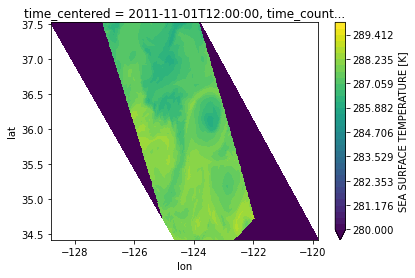

In [42]:
Ti[0].plot(x='lon',y='lat',levels=np.linspace(280,290,35))

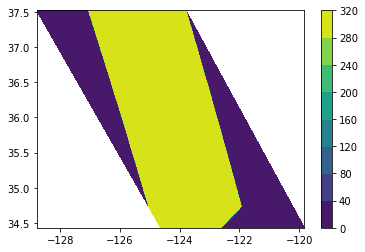

In [47]:
plt.contourf(lons,lats,Ti[0])
plt.colorbar()

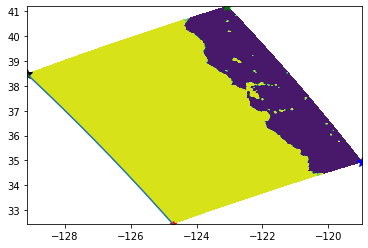

In [311]:
plt.contourf(varf.nav_lon,varf.nav_lat,varf.SST[0])
plt.plot(varf.nav_lon[0,0],varf.nav_lat[0,0],'r*')
plt.plot(varf.nav_lon[-1,-1],varf.nav_lat[-1,-1],'g*',markersize=10)
plt.plot(varf.nav_lon[0,-1],varf.nav_lat[0,-1],'b*',markersize=10)
plt.plot(varf.nav_lon[-1,0],varf.nav_lat[-1,0],'k*',markersize=10)
plt.plot(varf.nav_lon[:,0],varf.nav_lat[:,0])


In [304]:
sw.dist(lon=[varf.nav_lon[-1,0],varf.nav_lon[0,0]],lat=[varf.nav_lat[-1,0],varf.nav_lat[0,0]])[0]

array([2.010117 , 2.0101507, 2.0099514, 2.010888 , 2.0095656, 2.009373 ,
       2.0105288, 2.0089824, 2.0105891, 2.0099452, 2.0090806, 2.0100064,
       2.0102637, 2.0096202, 2.0103247, 2.0101314, 2.0094883, 2.0106425,
       2.0095503, 2.0100312, 2.0091636, 2.0096436, 2.0107973, 2.010379 ,
       2.009513 , 2.0097675, 2.010248 , 2.010054 , 2.0089643, 2.0101173,
       2.010147 , 2.010181 , 2.008864 , 2.0113626, 2.009375 , 2.0103033,
       2.010339 , 2.009915 , 2.0099497, 2.0090864, 2.0104609, 2.010266 ,
       2.0096257, 2.0092082, 2.0108137, 2.009719 , 2.0102017, 2.0095618,
       2.0100346, 2.0100727, 2.0101001, 2.0108051, 2.0095   , 2.0092926,
       2.0102327, 2.0098157, 2.0102859, 2.0105479, 2.0099092, 2.0097136,
       2.009297 , 2.0097814, 2.011151 , 2.0091689, 2.0096536, 2.0119078,
       2.0095017, 2.0090668, 2.0106742, 2.0091348, 2.0105233, 2.0100865,
       2.0090077, 2.0108373, 2.0095181, 2.0100043, 2.009808 , 2.0105145,
       2.0100977, 2.0099015, 2.010388 , 2.008629 , 

In [395]:
# sx=sw.dist(lon=varf.nav_lon[-1,:].compute(),lat=varf.nav_lat[-1,:].compute())[0]
# Xs=np.cumsum(np.insert(sx,0,0))


sx=sw.dist(lon=[varf.nav_lon[-1,0].compute(),varf.nav_lon[-1,-1].compute()],
           lat=[varf.nav_lat[-1,0].compute(),varf.nav_lat[-1,-1].compute()])[0]
# Xs=np.linspace(0,sx,varf.nav_lon.shape[1]).round(3)
Xs=np.arange(0,300,1)


# sy=sw.dist(lon=varf.nav_lon[:,0].compute(),lat=varf.nav_lat[:,0].compute())[0]
# Ys=np.cumsum(np.insert(sy,0,0))


sy=sw.dist(lon=[varf.nav_lon[0,0].compute(),varf.nav_lon[-1,0].compute()],
           lat=[varf.nav_lat[0,0].compute(),varf.nav_lat[-1,0].compute()])[0]
# Ys=np.linspace(0,sy,varf.nav_lon.shape[0]).round(1)
Ys=np.arange(0,390,1)

Xs,Ys=np.meshgrid(Xs,Ys)


In [396]:
Xs.shape

(390, 300)

In [397]:
varf=varf.assign_coords(Xs=(["y", "x"], Xs))
varf=varf.assign_coords(Ys=(["y", "x"], Ys))

In [398]:
dx=((np.diff(varf.nav_lon[0,:])).mean() + np.diff(varf.nav_lon[-1,:]).mean())/2
dy=np.abs((np.diff(varf.nav_lon[:,0])).mean() + np.diff(varf.nav_lon[:,-1]).mean())/2

In [406]:
np.diff(Xs[:,3])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [408]:
AAF=xrft.isotropic_power_spectrum(varf.SST[0],nfactor=1,truncate='True',detrend='linear',coords=['Xs','Ys'], window=True)


ValueError: The input array contains coordinate variable(s) (['nav_lat', 'nav_lon', 'Xs', 'Ys']) whose dims include the transform dimension(s) `y`. Please drop these coordinates (`.drop(['nav_lat', 'nav_lon', 'Xs', 'Ys']`) before invoking xrft.